In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from src.models.components.mlp import MyMLP

import torch
import torchsde
from functorch import vmap
from torchdiffeq import odeint

from src.energies.gmm_energy import GMM

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


### Target Distribution

In [15]:
target = GMM(dimensionality=2,
             n_mixes=40,
             loc_scaling= 40,
             log_var_scaling=1.0,
             device=device,
             should_unnormalize=True)

## Function Definitions

In [6]:
from src.models.components.sdes import VEReverseSDE
from src.models.components.sde_integration import integrate_sde
from src.models.components.clipper import Clipper
from src.models.components.score_estimator import estimate_grad_Rt

In [7]:
from src.models.components.noise_schedules import GeometricNoiseSchedule, LinearNoiseSchedule
# noise_schedule = GeometricNoiseSchedule(sigma_min=0.000004, sigma_max=0.4)
beta = torch.tensor(0.2)
noise_schedule = LinearNoiseSchedule(beta)

In [8]:
clipper = Clipper(
    should_clip_scores=False, should_clip_log_rewards=False, max_score_norm=50
)

In [8]:
# calculate the log expectation of the reward
def log_E_R(_x, _t, noise_schedule, num_mc_samples, var_exploding=True):
    repeated_x = _x.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
    repeated_t = _t.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
    h_t  = noise_schedule.h(repeated_t) 
    h_t = h_t.unsqueeze(1)

    samples = repeated_x + torch.randn(repeated_x.shape).to(device) * (h_t ** 0.5)
    # log_rewards = target(target.unnormalize(samples))
    log_rewards = target(samples)
    log_expectation_R = torch.logsumexp(log_rewards, dim=-1) - np.log(num_mc_samples)
    return log_expectation_R

In [9]:
def estimate_grad_Rt(x, t, noise_schedule, num_mc_samples=100, var_exploding=True, richardson=False):
    est_scores_n = torch.func.grad(log_E_R)(x, t, noise_schedule, num_mc_samples, var_exploding=var_exploding)
    if richardson:
        est_scores_n_div2 = torch.func.grad(log_E_R)(x, t, noise_schedule, num_mc_samples//2, 
                                                                                         var_exploding=var_exploding)
        return (2*est_scores_n - est_scores_n_div2)
    else:
        return est_scores_n

In [10]:
# calculate the log expectation of the reward
def estimate_grad_Rt_2(_x, _t, noise_schedule, num_mc_samples=100):
    
    repeated_x = _x.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
    repeated_t = _t.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
    h_t  = noise_schedule.h(repeated_t).unsqueeze(1)
    
    samples = repeated_x + torch.randn(repeated_x.shape).to(device) * (h_t ** 0.5)
    
    log_rewards = target(samples)

    log_w = log_rewards
    # grad_log_rewards = torch.vmap(torch.func.grad(lambda x: target(x)))(samples)
    grad_log_rewards =  (samples - repeated_x) / h_t
    
    estimate = torch.sum(torch.nn.functional.softmax(log_w, dim=0)[:, None] * grad_log_rewards, dim=-2)
    return estimate

In [11]:
# calculate the log expectation of the reward
def estimate_grad_Rt_3(_x, _t, _x_target_samples, noise_schedule, num_mc_samples=500):
    repeated_x = _x.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
    repeated_t = _t.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
    h_t  = noise_schedule.h(repeated_t)

    log_weights = -torch.linalg.vector_norm((_x_target_samples - repeated_x), dim=-1) ** 2 / (2 * h_t)

    grad_log_rewards = torch.vmap(torch.func.grad(lambda x: target(x)))(_x_target_samples)

    estimate = torch.sum(torch.nn.functional.softmax(log_weights, dim=0)[:, None] * grad_log_rewards, dim=-2)

    return estimate, _x_target_samples

In [12]:
# calculate the log expectation of the reward
def estimate_grad_Rt_4(_x, _t, _x_target_samples, noise_schedule, num_mc_samples=500):
    repeated_x = _x.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
    repeated_t = _t.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
    h_t  = noise_schedule.h(repeated_t)

    log_weights = -torch.linalg.vector_norm((_x_target_samples - repeated_x), dim=-1) ** 2 / (2 * h_t)

    grad_log_transition_kernel =  (_x_target_samples - repeated_x) / h_t.unsqueeze(1)

    estimate = torch.sum(torch.nn.functional.softmax(log_weights, dim=0)[:, None] * grad_log_transition_kernel, dim=-2)

    return estimate, _x_target_samples

In [13]:
class VEReverseSDE(torch.nn.Module):
    noise_type = 'diagonal'
    sde_type = 'ito'
    
    def __init__(self, score, noise_schedule):
        super().__init__()
        self.score = score
        self.noise_schedule = noise_schedule
    
    def f(self, t, x):
        with torch.enable_grad():
            if t.dim() == 0:
                # repeat the same time for all points if we have a scalar time
                t = t * torch.ones(x.shape[0]).to(device)

            # uncomment for true     
            # x.requires_grad = True
            # score = self.score(x, 1-t, self.noise_schedule)


            num_mc_samples = 500
            target_samples = target.gmm.sample((x.shape[0] * num_mc_samples, 1))
            target_samples = target.normalize(target_samples)
            target_samples = target_samples.reshape(x.shape[0], num_mc_samples, -1)
            # score, _ = torch.vmap(self.score, randomness="different", in_dims=(0,0,0,None))(x, t, target_samples, self.noise_schedule)
            score  = torch.vmap(self.score, randomness="different", in_dims=(0,0,None))(x, t, self.noise_schedule)
            
        return self.g(t, x)**2 * score 
    
    # def g(self, t, x=None):
    #     return self.noise_schedule.g(t.unsqueeze(1))
    
    def g(self, t, x):
        g = self.noise_schedule.g(t)
        return g.unsqueeze(1) if g.ndim > 0 else torch.full_like(x, g)

In [14]:
def reward_matching_loss_biased(vectorfield, energy_fn, x, t, noise_schedule,
                                weighted=False, num_mc_samples=100):
    h_t = noise_schedule.h(t.unsqueeze(1))

    # x.requires_grad = True
    # noisy sample: x(t)
    noisy_x = torch.normal(x, h_t**0.5)
    pred_scores = vectorfield(t, noisy_x)

    # estimated_scores = estimate_grad_Rt_2(noisy_x, t, noise_schedule, num_mc_samples=num_mc_samples).detach()
    estimated_scores = torch.vmap(estimate_grad_Rt_2, in_dims=(0, 0, None), randomness="different")(noisy_x,
                                                                                                    t,
                                                                                                    noise_schedule,
                                                                                                    num_mc_samples=num_mc_samples
                                                                                                    ).detach()
    estimated_scores = clipper.clip_scores(estimated_scores)

    if weighted:
        lambda_t = h_t + 1e-3
        err = (
            estimated_scores - pred_scores
        ) ** 2  # torch.linalg.vector_norm((estimated_scores - pred_scores), dim=-1)**2
        return (lambda_t * err).mean()
    else:
        err = (
            estimated_scores - pred_scores
        ) ** 2  # torch.linalg.vector_norm((estimated_scores - pred_scores), dim=-1)**2
        return err.mean()

### SDE Tests

In [9]:
def generate_samples(reverse_sde, num_samples, return_full_trajectory, diffusion_scale):
    samples = prior.sample(num_samples)
    return integrate(
        reverse_sde=reverse_sde,
        samples=samples,
        return_full_trajectory=return_full_trajectory,
        diffusion_scale = diffusion_scale
    )


def integrate(reverse_sde, samples, return_full_trajectory=False, diffusion_scale=1.0):
    trajectory = integrate_sde(
        reverse_sde,
        samples,
        1000,
        target,
        reverse_time=True,
        diffusion_scale=diffusion_scale
    )
    if return_full_trajectory:
        return trajectory
    return trajectory[-1]

In [10]:
from src.energies.base_prior import Prior
prior = Prior(dim=2, device=device, scale = noise_schedule.h(1) ** 0.5)
x1_samples = prior.sample(1000)
x1_energy = target(x1_samples)

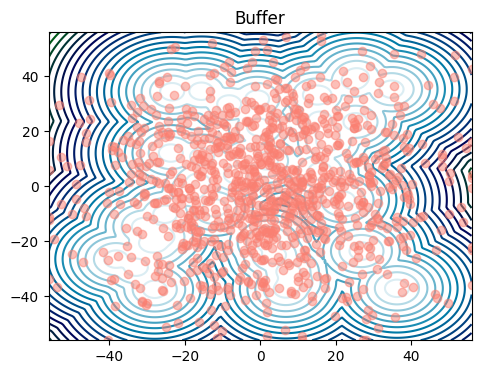

In [19]:
target.get_dataset_fig(target.unnormalize(x1_samples), color="salmon");

In [39]:
noise_schedule = LinearNoiseSchedule(beta)
ve_reverse_sde = VEReverseSDE(estimate_grad_Rt_2, noise_schedule)
samples = integrate(ve_reverse_sde, x1_samples, return_full_trajectory=True, diffusion_scale=1.0)

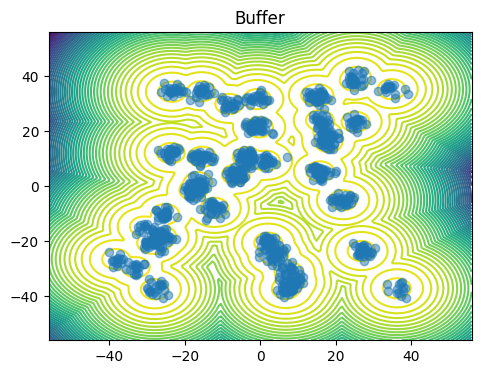

In [40]:
target.get_dataset_fig(target.unnormalize(samples[-1]));

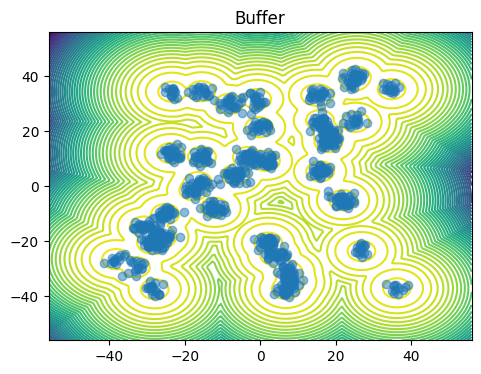

In [29]:
target.get_dataset_fig(target.unnormalize(samples[-1]));

In [20]:
times = torch.linspace(1, 0, 1000).to(device)
ind = 900
x_t = samples[ind]
t = times[ind]
t = torch.tensor([t]).to(device).repeat(x_t.shape[0])


target_samples = target.gmm.sample((x_t.shape[0]*100,))
target_samples = target.normalize(target_samples)
target_samples = target_samples.reshape(x_t.shape[0], 100, -1)

In [39]:
score, weighted_samples = torch.vmap(estimate_grad_Rt_3, randomness="different", in_dims=(0,0,0,None))(x_t, t, target_samples, noise_schedule, num_mc_samples=100)

/tmp/ipykernel_2478411/504644348.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  indices = torch.multinomial(torch.nn.functional.softmax(log_weights),


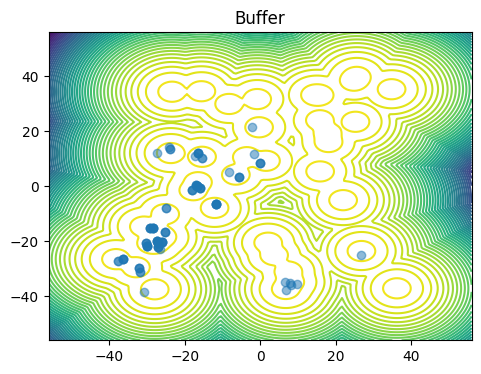

In [27]:
target.get_dataset_fig(target.unnormalize(weighted_samples[10]));

### Training

In [20]:
from src.models.components.prioritised_replay_buffer import SimpleBuffer
buffer = SimpleBuffer(
    2,
    10000,
    1000,
    initial_sampler=None,
    device=device,
    fill_buffer_during_init=False,
    sample_with_replacement=True,
    prioritize=False,
)
buffer.add(x1_samples, x1_energy)

Buffer not initialised, expected that checkpoint will be loaded.


In [21]:
outer_epochs= 100
inner_epochs = 100

batch_size = 512
train_dataset = TensorDataset(x1_samples.clone(), x1_energy.clone())
trainloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) 

In [20]:
vectorfield = MyMLP().to(device)
optimizer = Adam(vectorfield.parameters(), lr=1e-3)
weighted = False

In [23]:
from src.models.components.sdes import VEReverseSDE

In [ ]:
def posterior_loss(vectorfield, target, x, t, noise_schedule, num_mc_samples=100):
    h_t = noise_schedule.h(t.unsqueeze(1))
    x_t = torch.normal(x, h_t**0.5)
    pred_posterior = vectorfield(t, x_t)

    x_t_repeated = x_t.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
    x_ = x_t_repeated + torch.randn(x_t_repeated.shape).to(device) * (h_t ** 0.5)
    t_ = t.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)

    pred_posterior = vectorfield(t, x_t)


    nabla_log_N =  (x_t_repeated - x_) / h_t.unsqueeze(1)

    err = (
        estimated_scores - pred_scores
    ) ** 2  # torch.linalg.vector_norm((estimated_scores - pred_scores), dim=-1)**2
    return err.mean()

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0 | Loss 43.522148
Epoch 49 | Loss 21.873110
Epoch 98 | Loss 15.149311


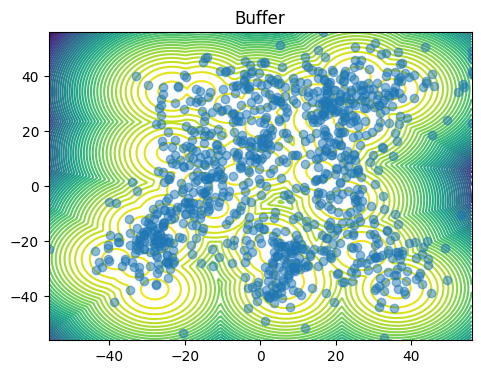

  1%|          | 1/100 [00:02<04:26,  2.69s/it]

Epoch 0 | Loss 20.360275
Epoch 49 | Loss 11.606435
Epoch 98 | Loss 7.306292


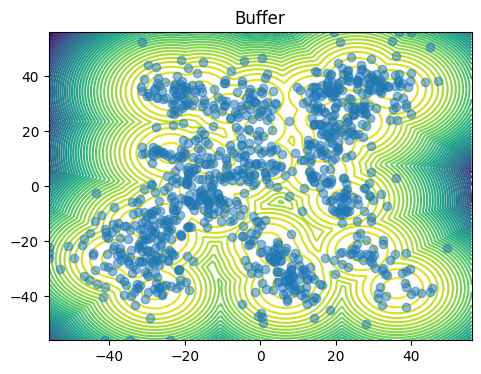

  2%|▏         | 2/100 [00:10<08:57,  5.49s/it]

Epoch 0 | Loss 5.628231
Epoch 49 | Loss 9.825218
Epoch 98 | Loss 12.006941


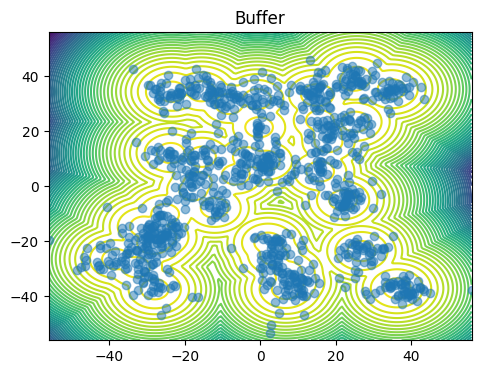

  3%|▎         | 3/100 [00:17<10:23,  6.43s/it]

Epoch 0 | Loss 9.256899


  3%|▎         | 3/100 [00:19<10:30,  6.50s/it]


KeyboardInterrupt: 

In [24]:
for epoch in tqdm(range(outer_epochs)):
    for epoch in range(inner_epochs):
        total_loss = 0.
        for samples,_ in trainloader:
            samples = samples.to(device)
            optimizer.zero_grad()

            t = torch.rand(len(samples), device=device)
            num_mc_samples = 100

            rm_loss = posterior_loss(vectorfield, target,
                                    samples, t, 
                                    noise_schedule, weighted=weighted,
                                    num_mc_samples=num_mc_samples) 
            loss = rm_loss.mean()
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

        if epoch % 49 == 0:
            print("Epoch %d | Loss %f" % (epoch, loss.item()))


    # Generate samples using the network
    ve_reverse_sde = VEReverseSDE(vectorfield, noise_schedule)
    samples = generate_samples(ve_reverse_sde, 1000, return_full_trajectory=False, diffusion_scale=1.5)
    samples_energy = target(samples)

    # Update Buffer 
    buffer.add(samples, samples_energy)

    target.get_dataset_fig(target.unnormalize(samples))
    plt.show()

    # Resample data from the buffer
    samples, samples_energy, _ = buffer.sample(512 * 10)
    train_dataset = TensorDataset(samples, samples_energy)
    trainloader = DataLoader(train_dataset, batch_size = 512, shuffle=True)